In [1]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from stable_baselines3 import A2C, PPO, DQN
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [ ]:
class GridEnv(gym.Env):
    """Custom Environment for Grid World"""

    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, grid, start, goal, max_steps):
        super().__init__()
        self.grid = np.array(grid, dtype=np.int8)
        self.size = self.grid.shape[0]
        self.start = start
        self.goal  = goal
        self.max_steps = max_steps
        self.current_step = 0
        self.agent_position = list(self.start)
        self.action_space = spaces.Discrete(4) # up, down, left, right
        self.observation_space = spaces.Box(low=0, high=255, shape=(3, self.size, self.size), dtype=np.uint8) # 0: free space, 255: obstacle, 64: agent, 128: goal


    def step(self, action):
        self.current_step += 1
        next_position = list(self.agent_position)
        prev_distance = np.linalg.norm(np.array(self.agent_position) - np.array(self.goal))
        
        if action == 0: next_position[0] -= 1 # up
        elif action == 1: next_position[0] += 1 # down
        elif action == 2: next_position[1] -= 1 # left
        elif action == 3: next_position[1] += 1 # right
        
        collision = False
        if 0 <= next_position[0] < self.size and 0 <= next_position[1] < self.size and self.grid[next_position[0], next_position[1]] == 0:
            self.agent_position = np.array(next_position, copy=True)
        else:
            collision = True

        obs = np.zeros((3, self.size, self.size), dtype=np.uint8)
        obs[0] = (self.grid == 1)        # obstacles
        obs[1, self.goal[0], self.goal[1]] = 1              # goal
        obs[2, self.agent_position[0], self.agent_position[1]] = 1  # agent
        obs *= 255

        # observation = obs[np.newaxis, :, :] # shape to (1, Size, Size)
        terminated = np.array_equal(self.agent_position, self.goal)
        truncated = self.current_step >= self.max_steps

        reward = 0
        if terminated:
            reward += 10
        elif collision:
            reward -= 0.1
        else:
            reward -= 0.01

        next_distance = np.linalg.norm(np.array(self.agent_position) - np.array(self.goal))
        distance = prev_distance - next_distance
        reward += distance * 0.01  # reward getting closer
        
        info = {}

        return obs, reward, terminated, truncated, info


    def reset(self, seed=None, options=None):
        obs = np.zeros((3, self.size, self.size), dtype=np.uint8)
        obs[0] = (self.grid == 1)        # obstacles
        obs[1, self.goal[0], self.goal[1]] = 1              # goal
        obs[2, self.start[0], self.start[1]] = 1  # agent  # agent
        obs *= 255

        # observation = obs[np.newaxis, :, :] # shape to (1, Size, Size)
        self.agent_position = list(self.start)
        self.current_step = 0
        info = {}
        
        return obs, info

    def render(self):
        obs = np.zeros((3, self.size, self.size), dtype=np.uint8)
        obs[0] = (self.grid == 1)        # obstacles
        obs[1, self.goal[0], self.goal[1]] = 1              # goal
        obs[2, self.agent_position[0], self.agent_position[1]] = 1  # agent
        obs *= 255

        observation = obs

        symbols = {0: '.', 1: '#', 2: 'A', 3: 'G'}
        print("\n".join(" ".join(symbols.get(v, '?') for v in row) for row in observation))
        print()

1.0


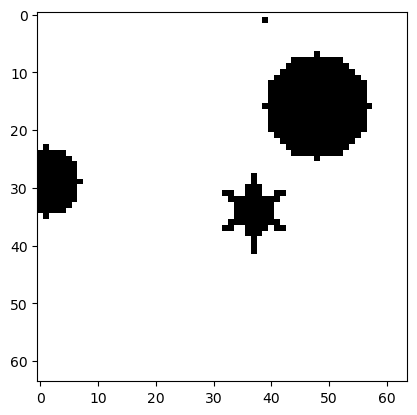

In [17]:
loaded = np.load('environments/environments_64_5_10000_1.npy')
loaded.shape

grid = loaded[0]
print(grid.max())
plt.imshow(grid, cmap='binary')

In [43]:
class ActionStoreCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.actions = []

    def _on_step(self):
        self.actions.append(self.locals["actions"])
        return True

In [79]:
grid = np.zeros((64,64))
start = (52,52)
goal = (62,62)
max_steps = 1000
lr = 3e-4

env = GridEnv(grid, start, goal, max_steps)




# Define and Train the agent
batch_size = 512
callback = ActionStoreCallback()
model = PPO("CnnPolicy", env, tensorboard_log="./rl_agent_static_tensorboard/", learning_rate=lr, batch_size=batch_size, n_steps=1024, device='cuda').learn(total_timesteps=100000, callback=callback, progress_bar=True)

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100,352/100,000  [ 0:04:08 < 0:00:00 , 404 it/s ]

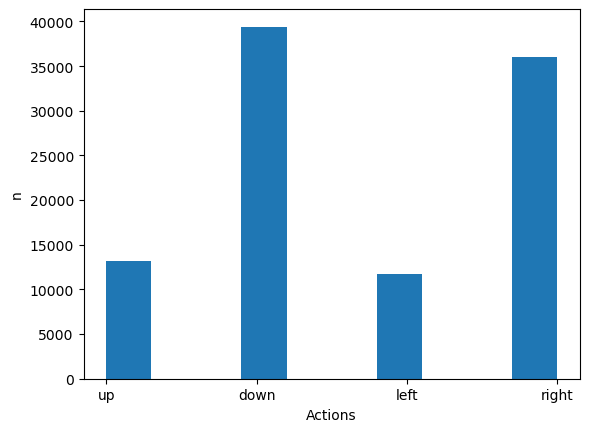

In [81]:
actions_array = np.array(callback.actions).flatten()
plt.hist(actions_array, label = 'Action Histogram')
plt.xlabel('Actions')
plt.ylabel('n')
plt.xticks([0,1,2,3], ['up', 'down', 'left', 'right'])
plt.show()

In [ ]:
n = 100
terminated_count = 0
truncated_count = 0
for i in tqdm(range(n)):
    obs, info = env.reset()
    for step in range(env.max_steps):
        action, _ = model.predict(obs, deterministic=True)
        
        obs, reward, terminated, truncated, info = env.step(action)
        
        if terminated or truncated:
            if terminated:
                terminated_count += 1
            elif truncated:
                truncated_count += 1
            break

print('terminated: ', terminated_count/n * 100, '%')

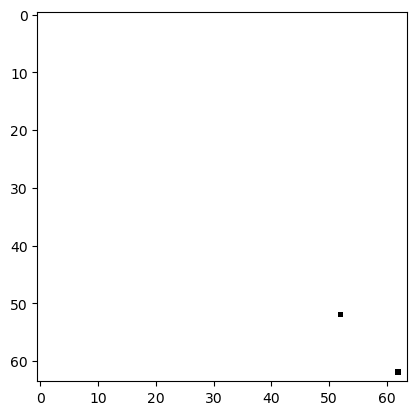

3


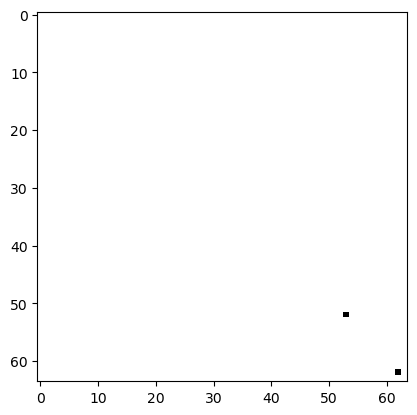

3


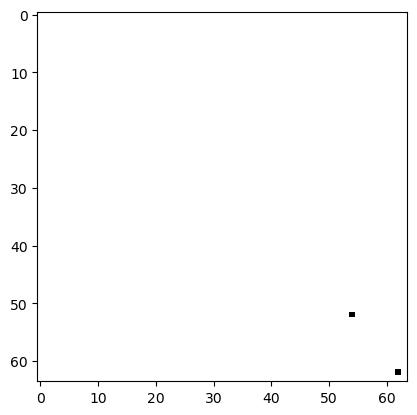

3


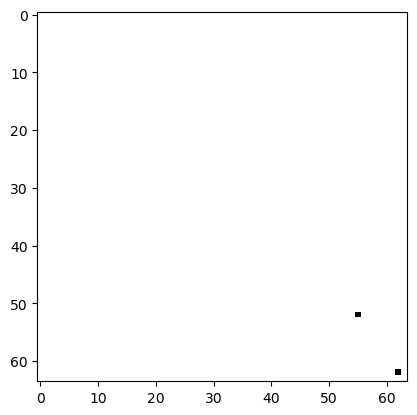

3


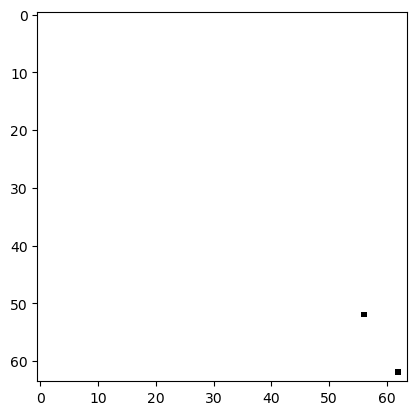

3


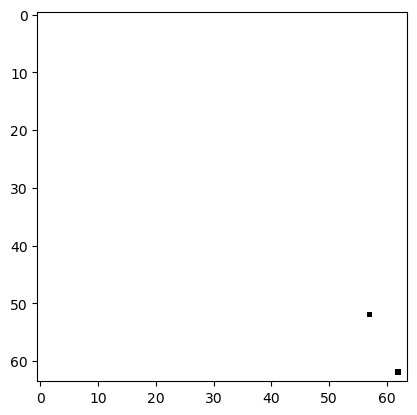

3


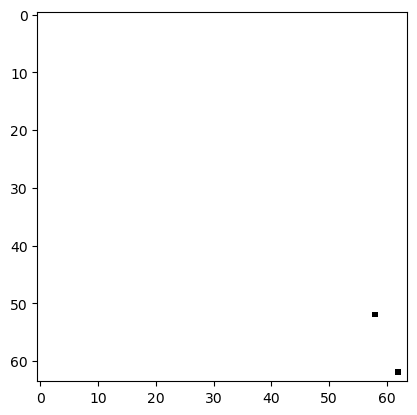

3


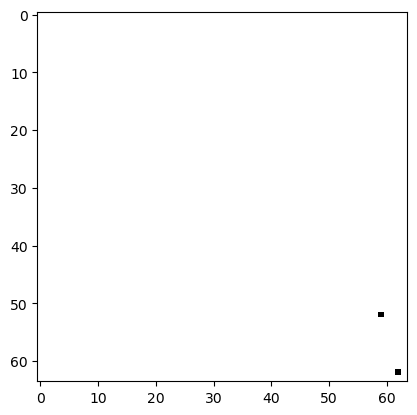

3


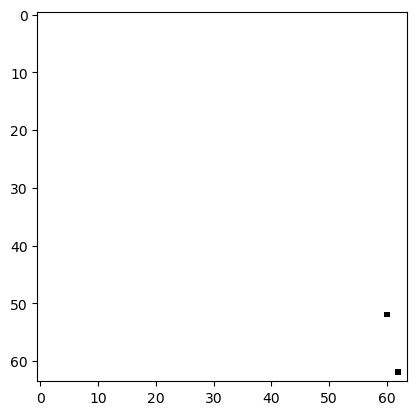

1


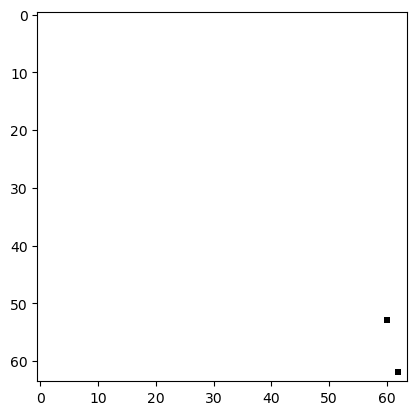

1


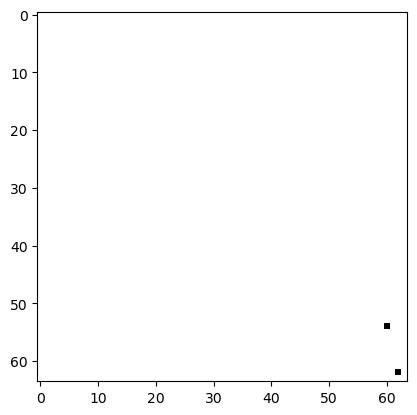

1


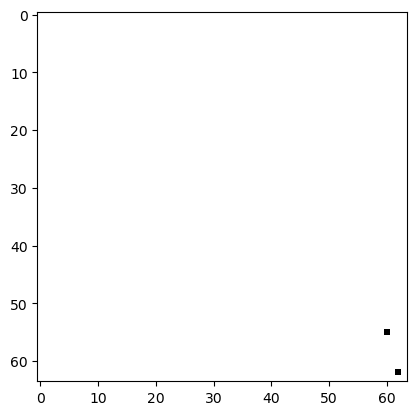

1


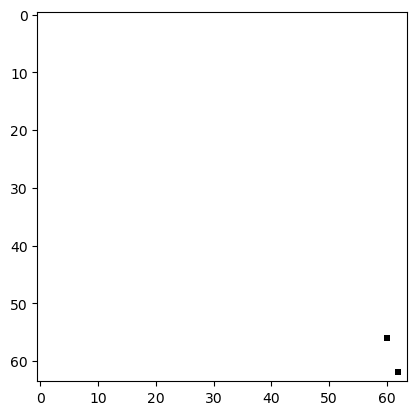

1


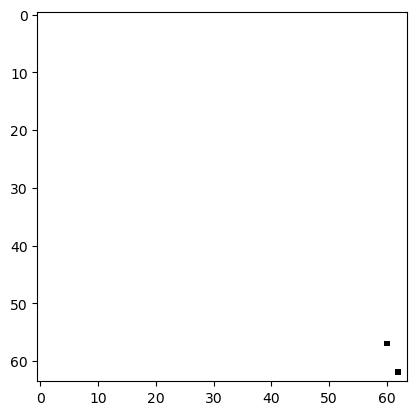

1


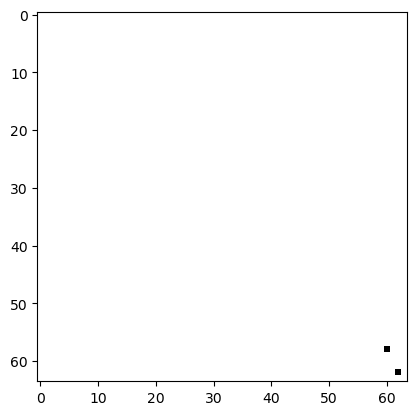

1


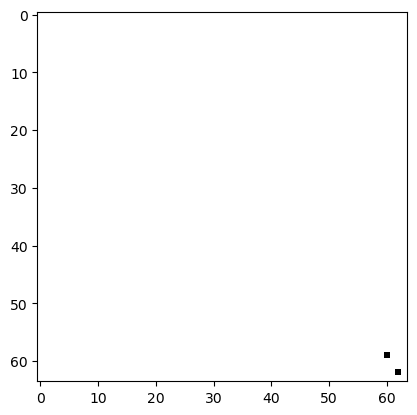

1


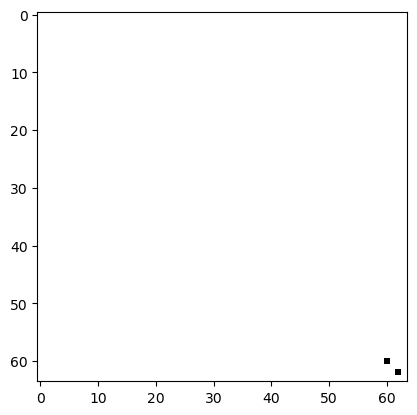

1


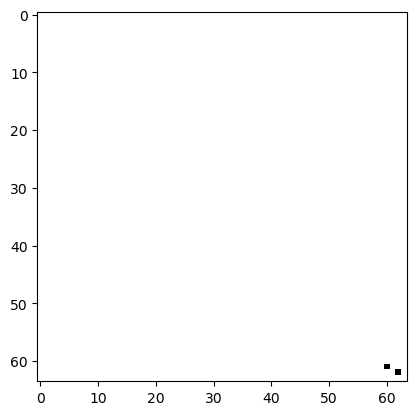

1


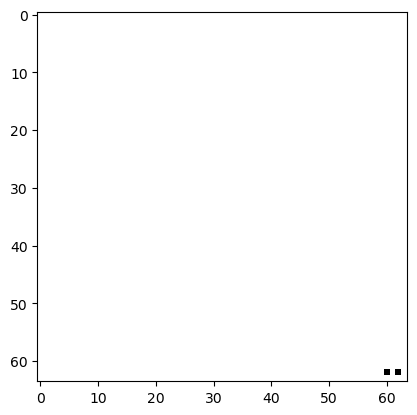

1


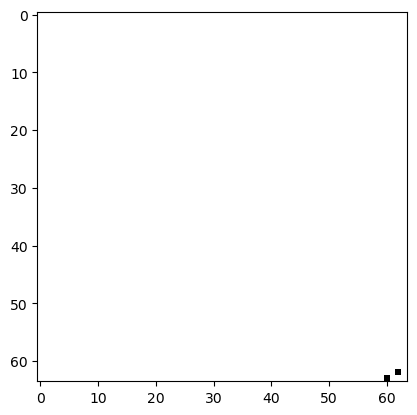

1


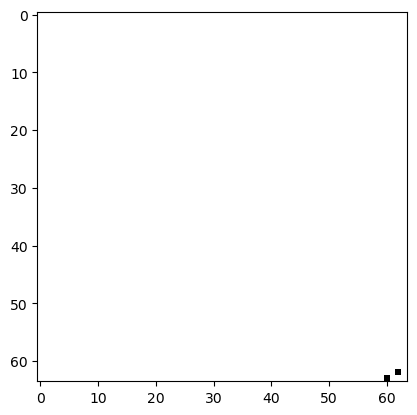

1


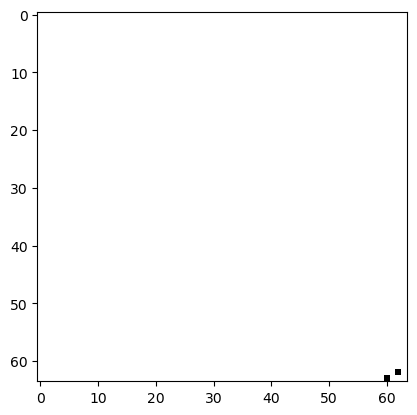

1


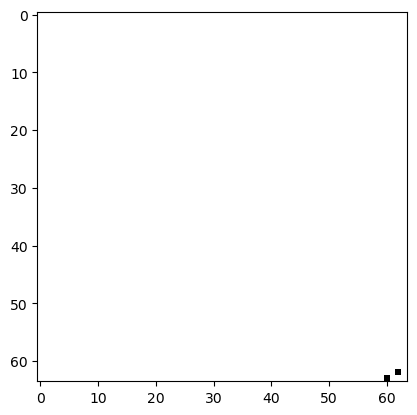

1


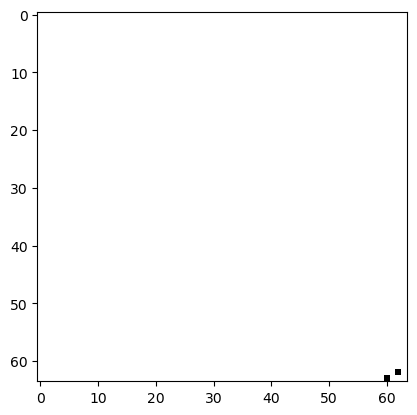

1


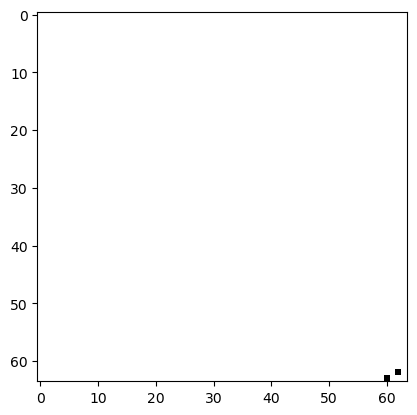

1


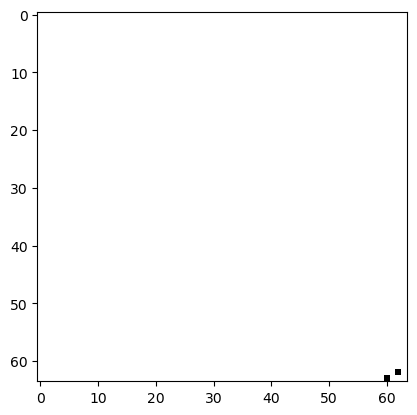

1


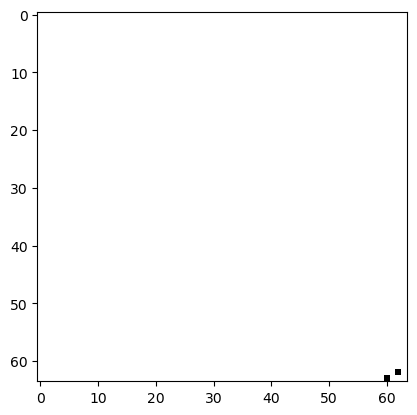

1


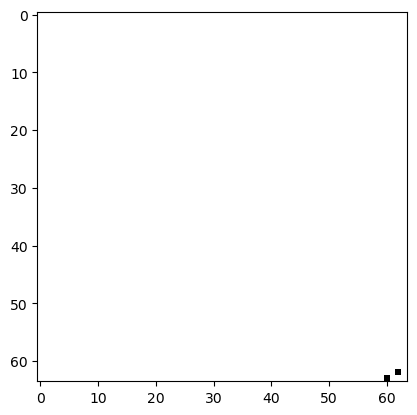

1


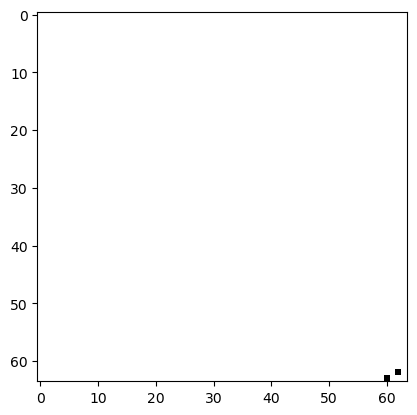

1


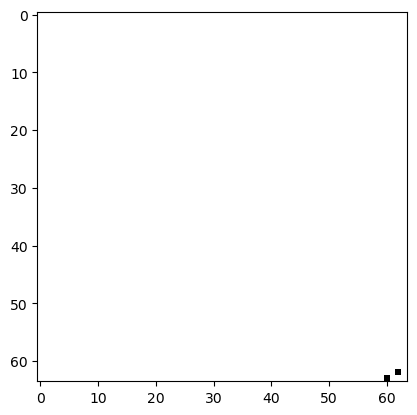

1


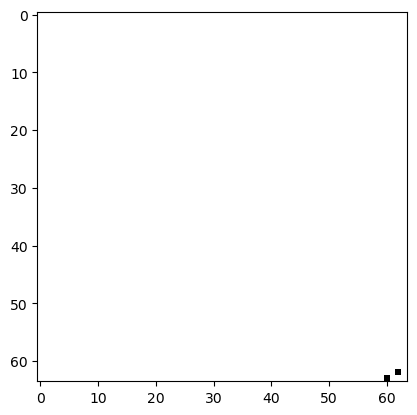

1


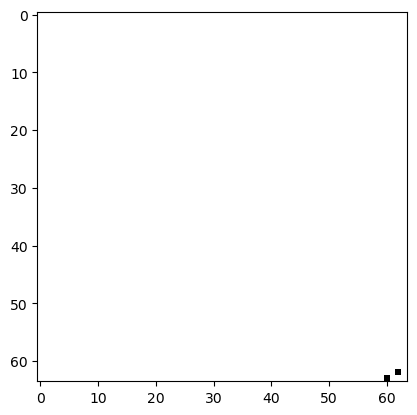

1


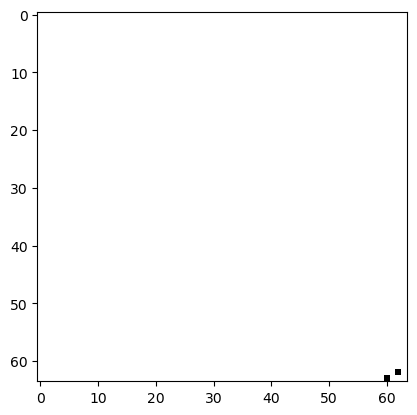

1


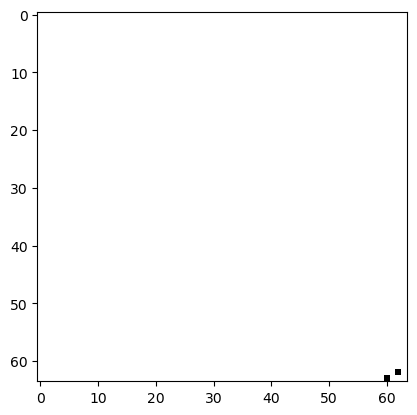

1


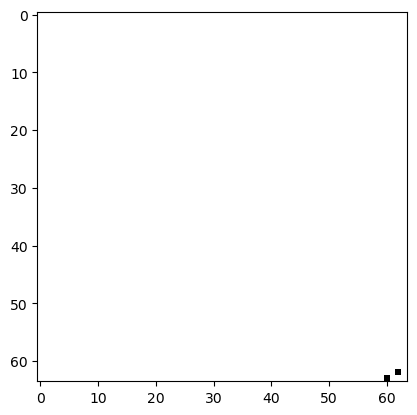

1


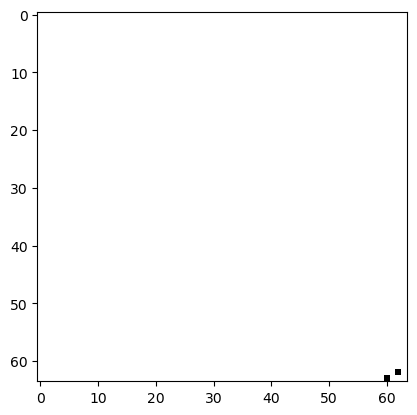

1


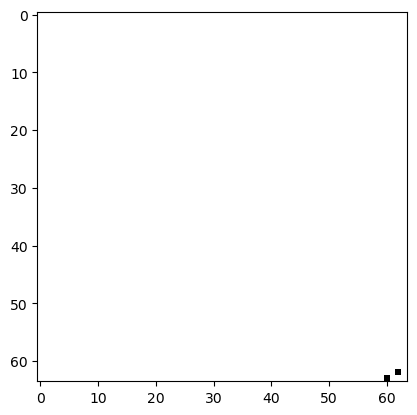

1


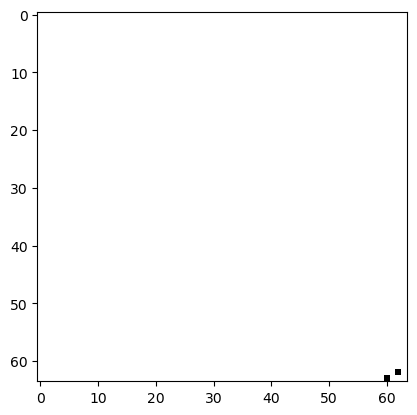

1


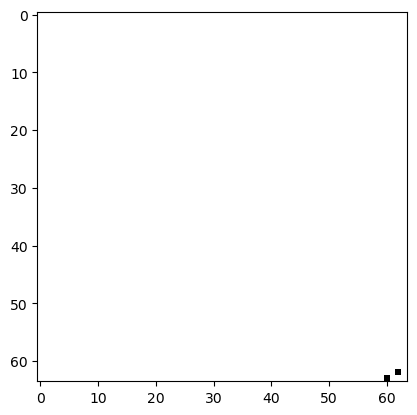

1


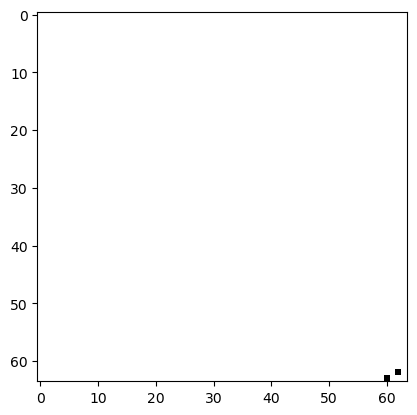

1


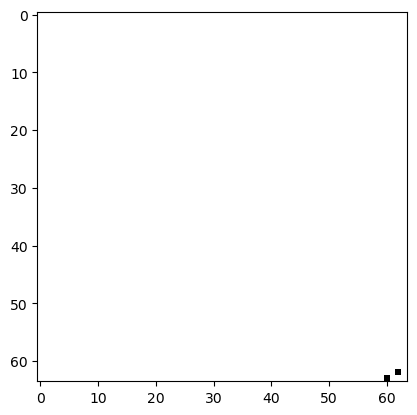

1


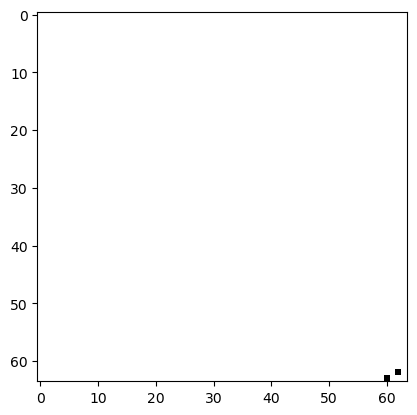

1


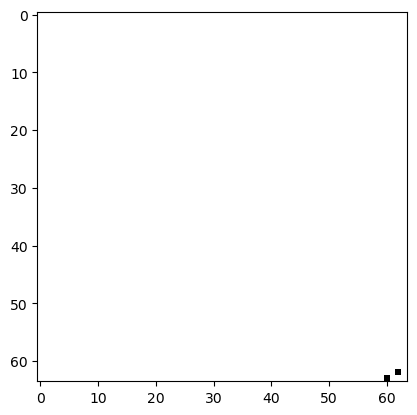

1


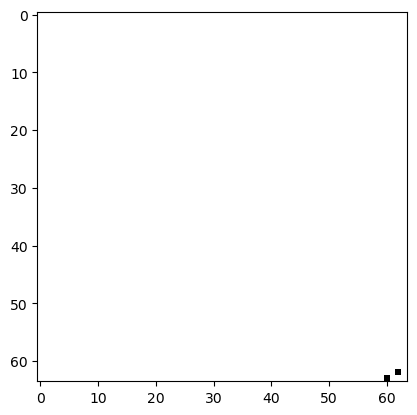

1


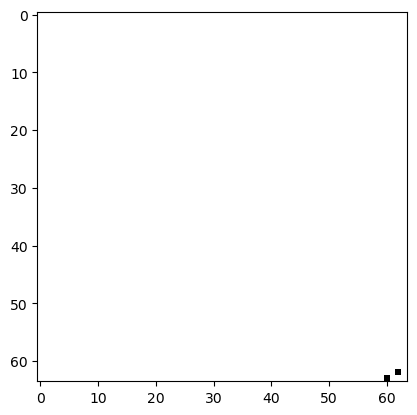

1


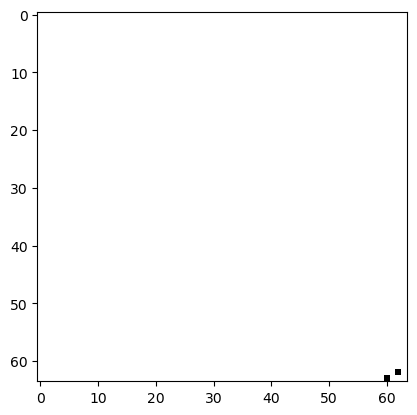

1


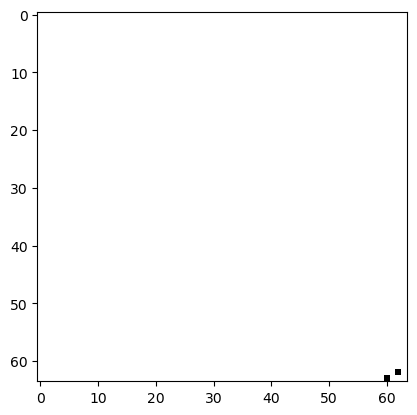

1


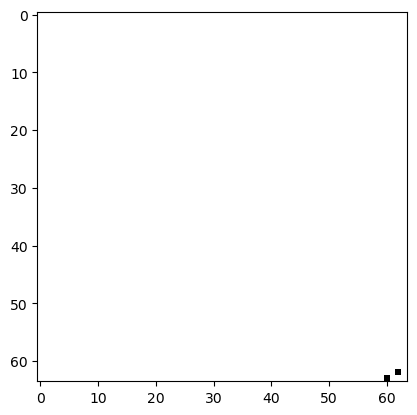

1


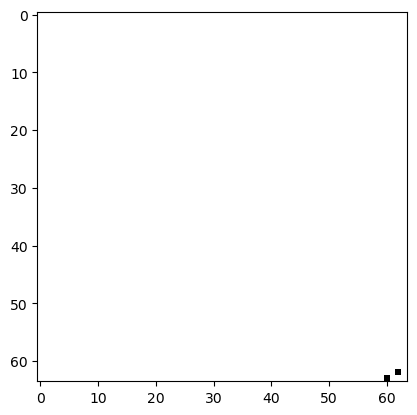

1


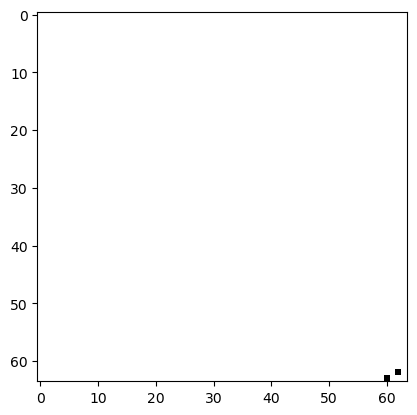

1


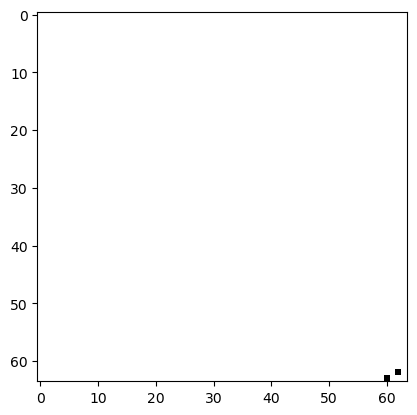

1


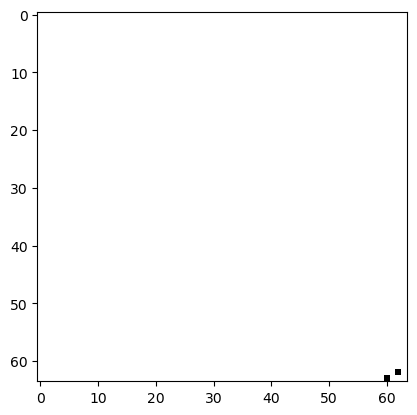

1


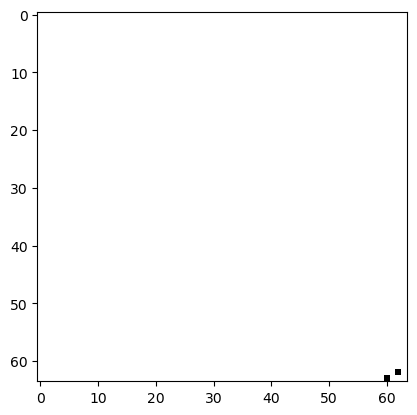

1


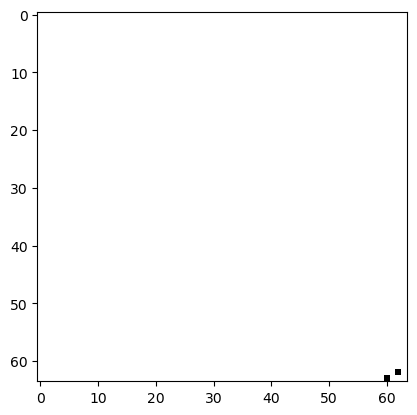

1


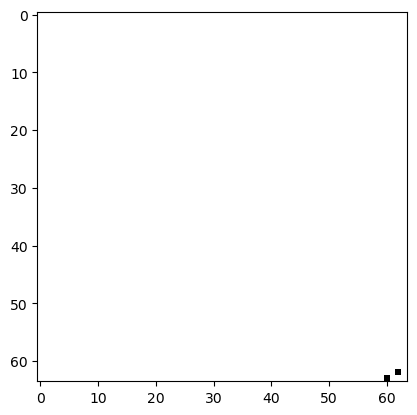

1


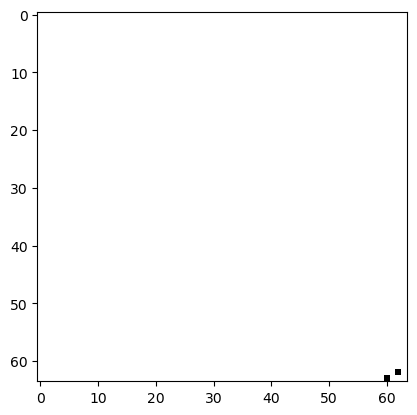

1


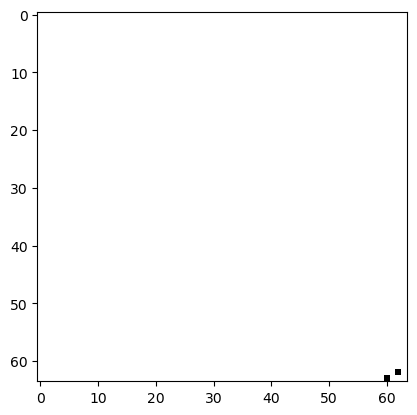

1


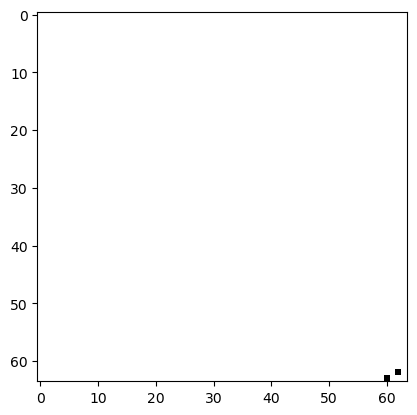

1


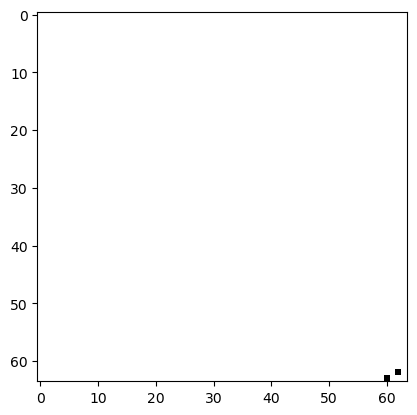

1


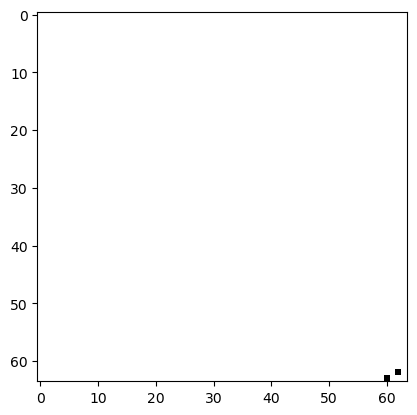

1


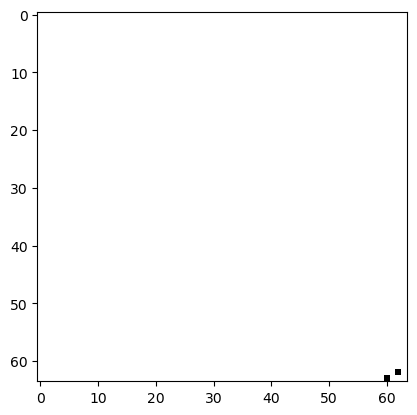

1


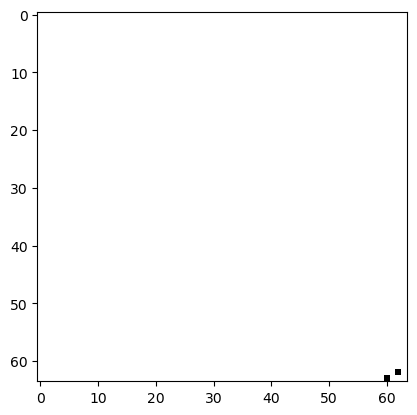

1


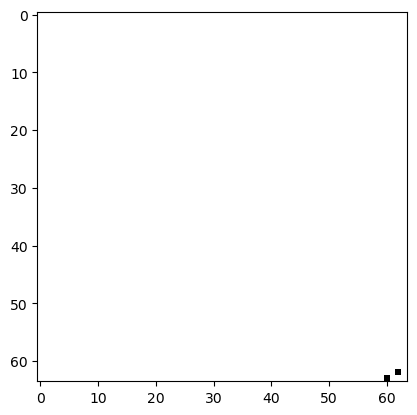

1


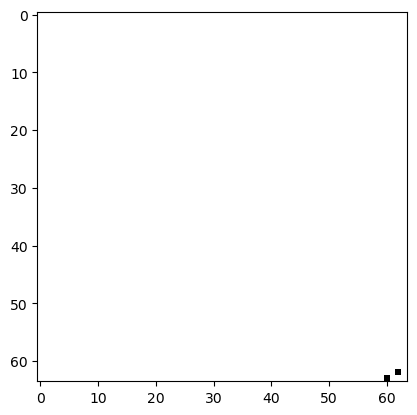

1


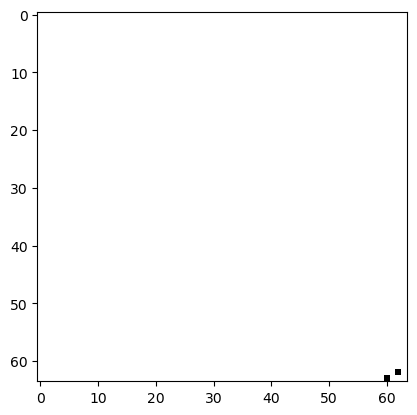

1


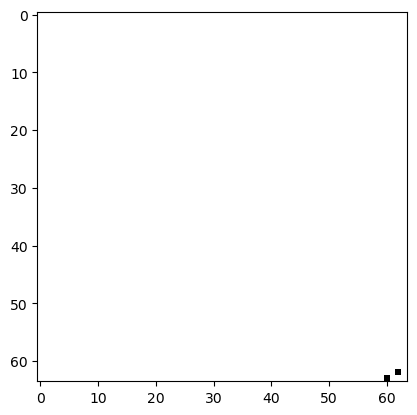

1


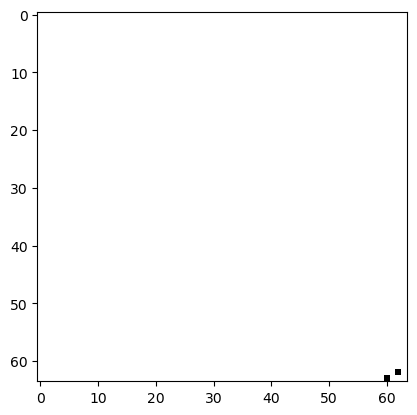

1


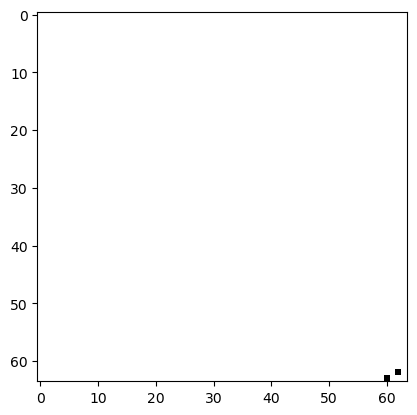

1


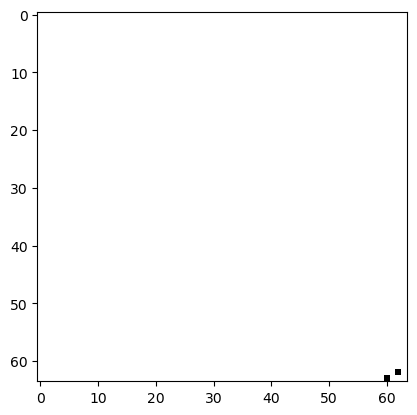

1


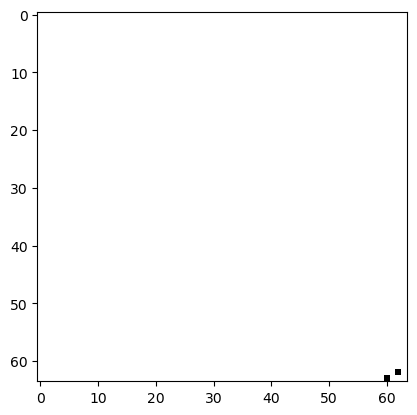

1


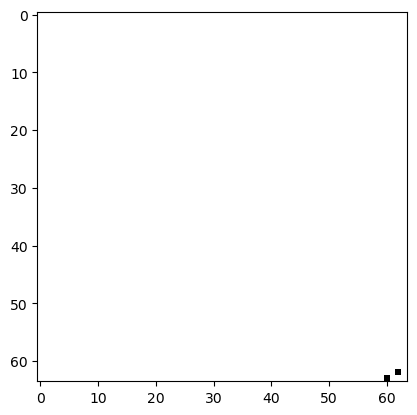

1


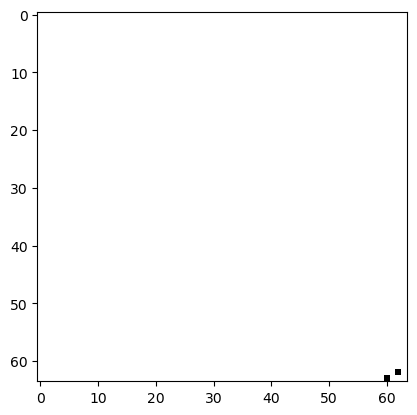

1


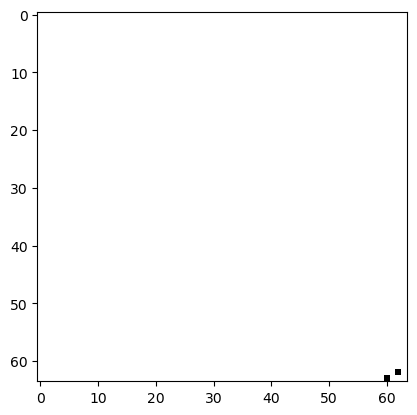

1


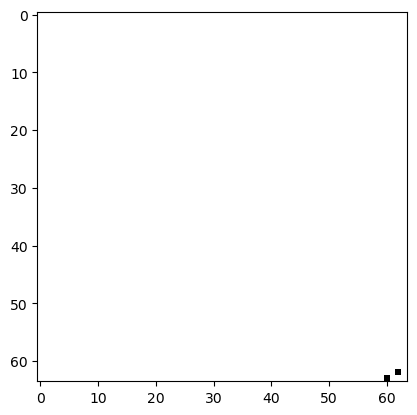

1


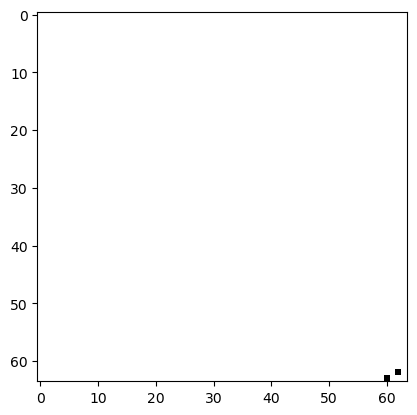

1


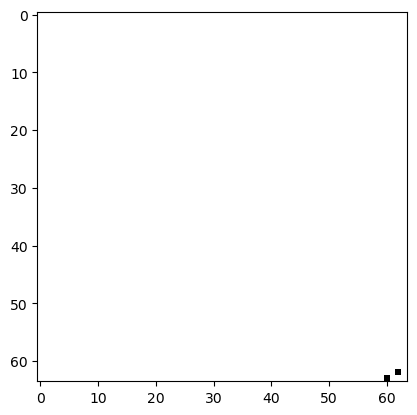

1


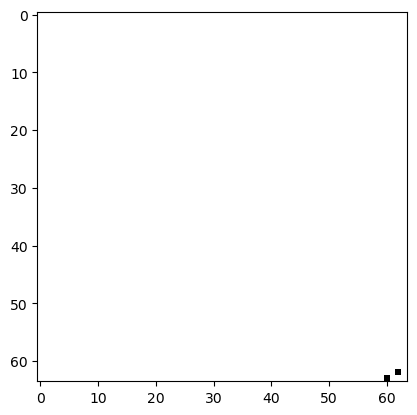

1


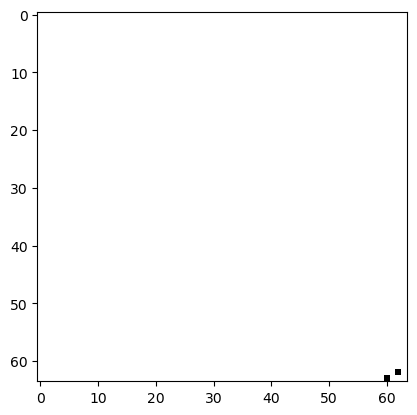

1


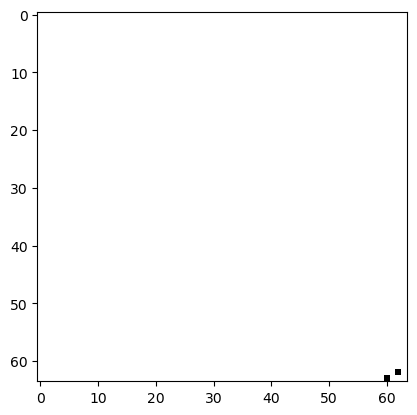

1


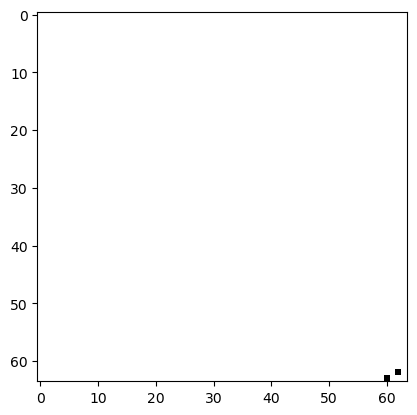

1


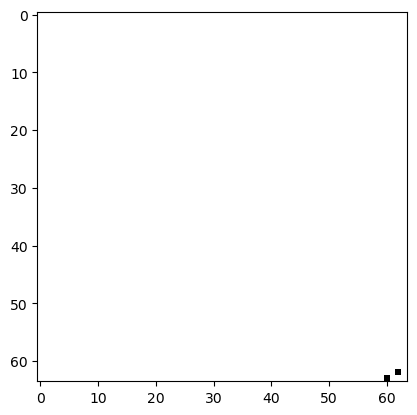

1


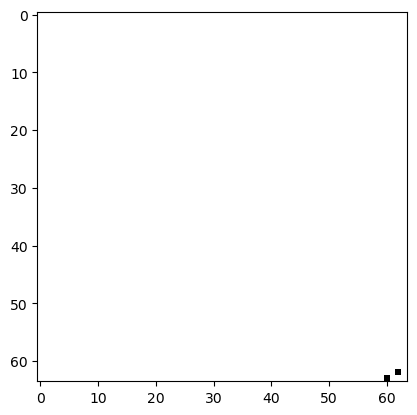

1


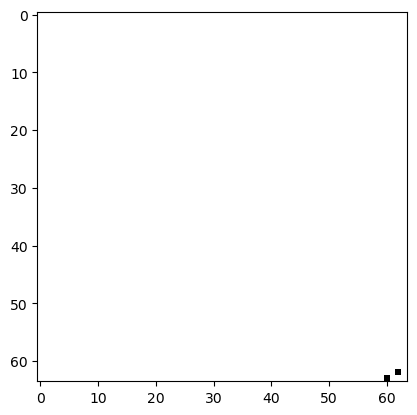

1


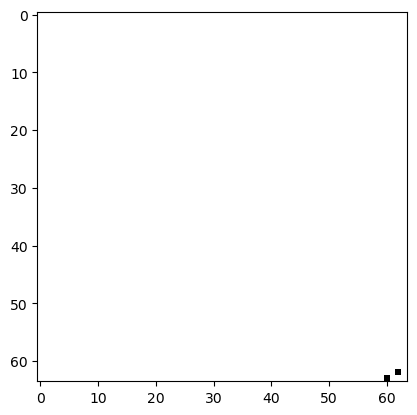

1


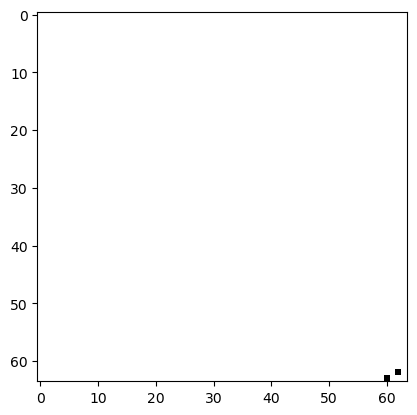

1


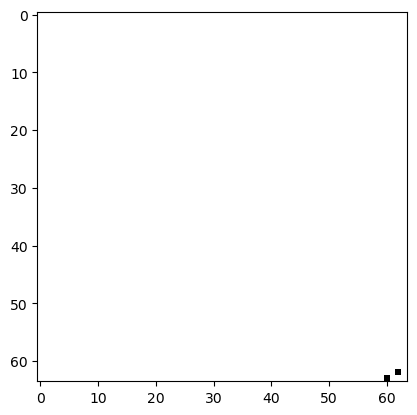

1


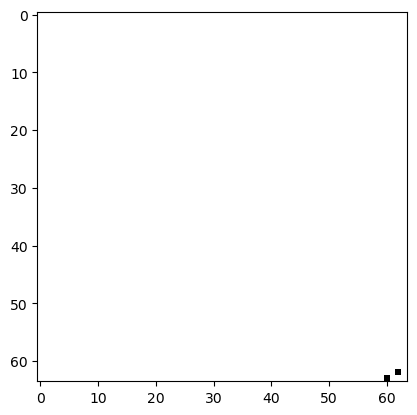

1


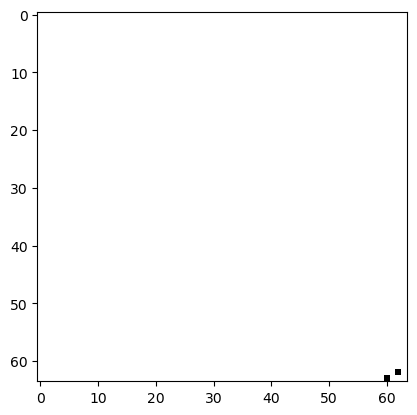

1


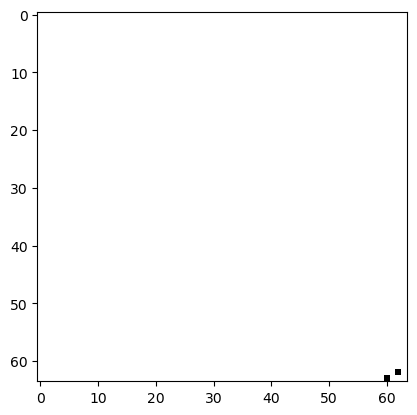

1


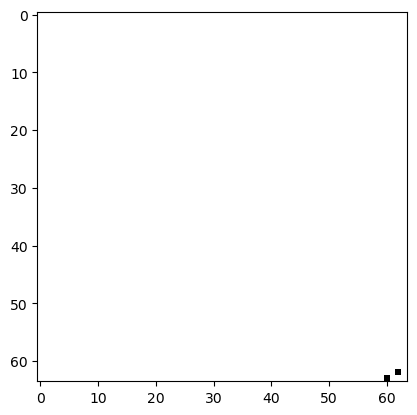

1


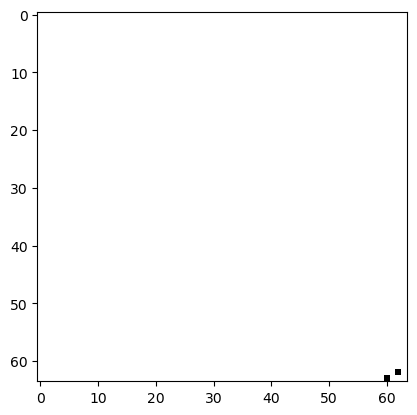

1


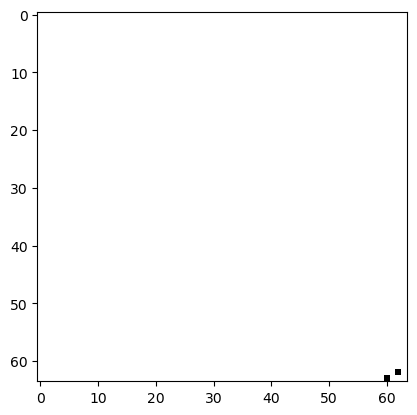

1


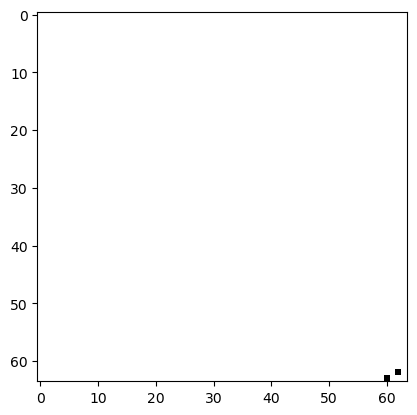

1


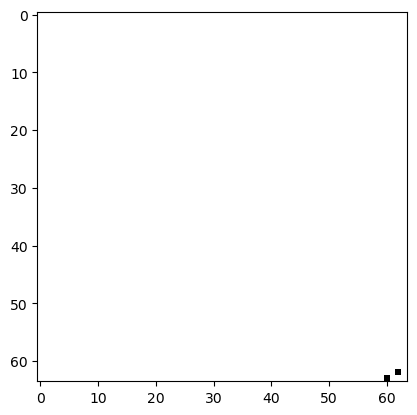

1


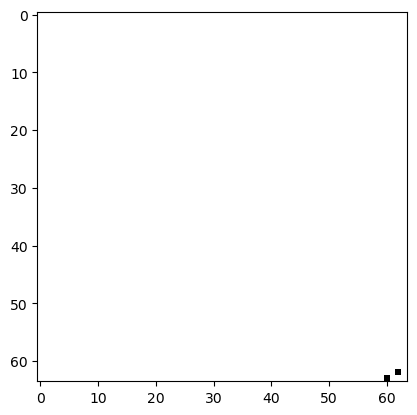

1


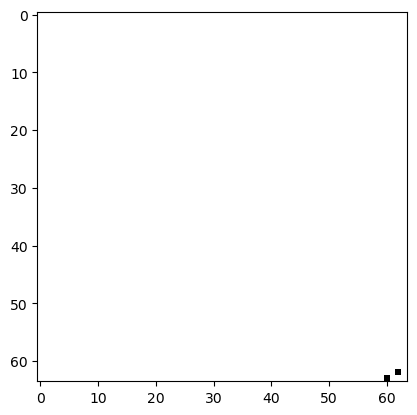

1


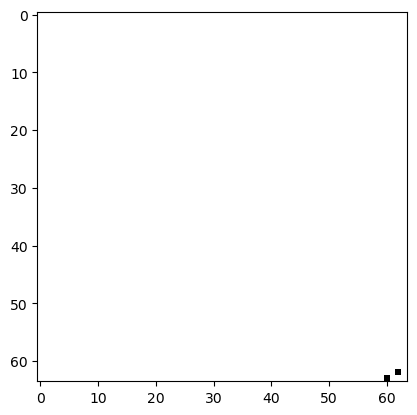

1


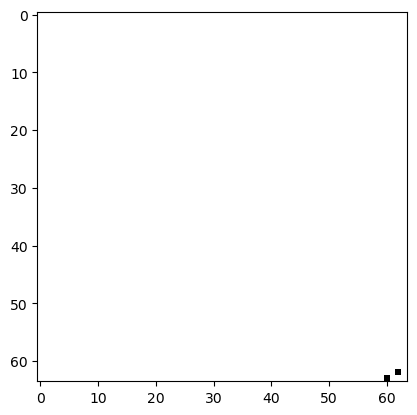

1


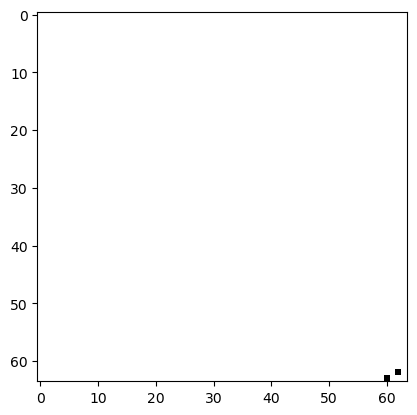

1


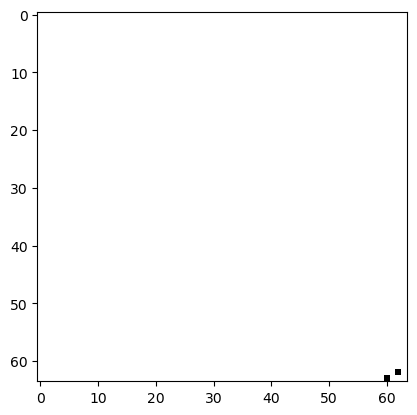

1


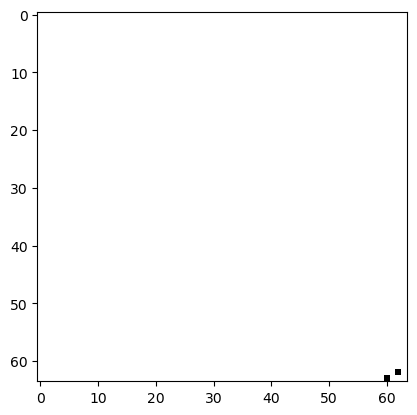

In [82]:
obs, info = env.reset()  # obs shape: (1, obs_dim)
plt.imshow(np.sum(obs, axis=0), cmap='binary')
plt.show()

for i in range(100):
    action, _ = model.predict(obs, deterministic=True)
    print(action)
        
    obs, reward, terminated, truncated, info = env.step(action)
    
    plt.imshow(np.sum(obs, axis=0), cmap='binary')
    plt.show()
    if terminated:
        break